## Data Processing

In [ ]:
# importing
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
import matplotlib
matplotlib.use('Agg')

In [ ]:
# use this method to upload the PIT (not manually cleaned) and HIC ("House Dataset.xlsx" already briefly cleaned) datasets as files
# => then later create dataframe variable for them

from google.colab import files
uploaded = files.upload()

### cleaning HIC dataset (housing dataset)

In [ ]:
df_dict = pd.read_excel("psh.xlsx", sheet_name=None)
# df_dict = df_dict.pop("Revisions", None)

all_sheets = []
for name, sheet in df_dict.items():
  sheet = sheet.iloc[:, 0:2]
  sheet['year'] = name
  all_sheets.append(sheet)

# psh means permanenet support housing
psh = pd.concat(all_sheets)
psh = psh.rename(columns={"Total PSH Beds": "psh_beds"})

# plotting
psh_coc = psh.groupby(by=["CoC", "year"], dropna=False, as_index=False).mean()
psh_coc_final = psh_coc.pivot(index="year", columns="CoC", values="psh_beds")

psh_coc_final.plot(figsize=(12, 10))
plt.ylabel("psh_beds")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


### cleaning PIT dataset (homelessness data)

In [ ]:
df2_dict = pd.read_excel("2007-2021-PIT-Counts-by-CoC.xlsx", sheet_name=None)

In [ ]:
all_sheets2 = []
for name, sheet in df2_dict.items():
  sheet1 = sheet.iloc[:, 0:185]
  sheet2 = sheet1.iloc[:, [0]+[3]+[-1]]
  sheet3 = sheet2.rename(columns={sheet2.columns[1]:"all_homeless", sheet2.columns[2]:"chronic_homeless"})
  sheet4 = sheet3.loc[sheet3['CoC Number'].str.startswith('MA', na=False)]
  sheet4["year"] = name
  all_sheets2.append(sheet4)

pit_final = pd.concat(all_sheets2)
pit_final = pit_final.rename(columns={"CoC Number": "CoC"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


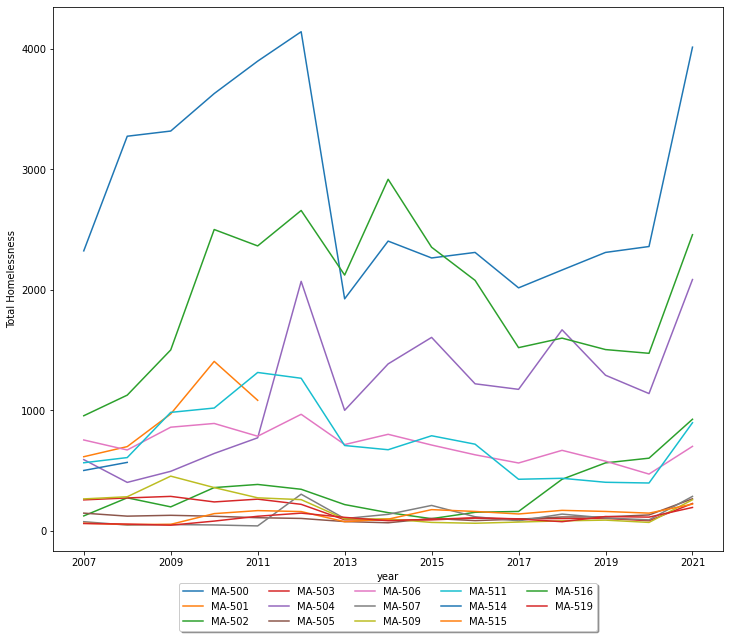

In [ ]:
# national PIT estimates of homelessness (OVERALL HOMELESSNESS)
all_homeless = pit_final.groupby(by=["CoC", "year"], dropna=False, as_index=False).mean()
all_homeless = all_homeless.pivot(index="year", columns="CoC", values="all_homeless") 

# plot
all_homeless.plot(figsize=(12, 10))
plt.ylabel("Total Homelessness")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

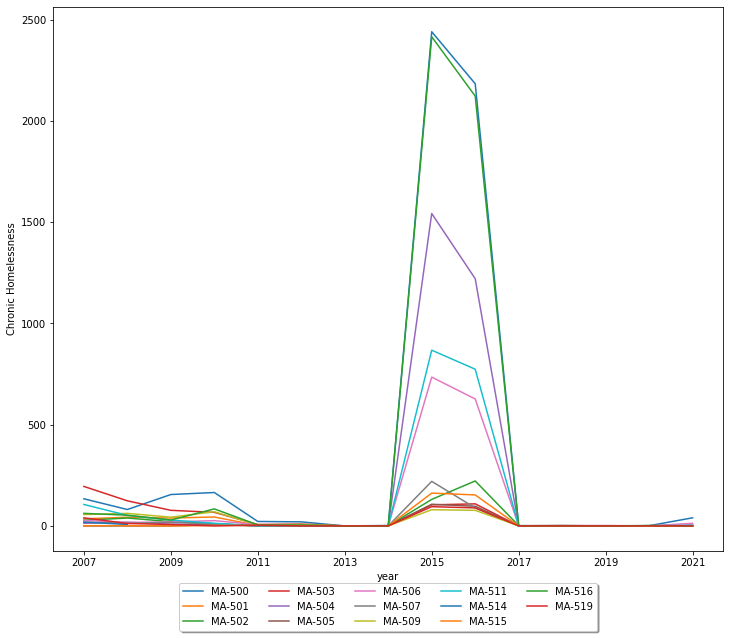

In [ ]:
# chronicPIT estimates of homelessness (CHRONIC HOMELESSNESS)
chronic_homeless = pit_final.groupby(by=["CoC", "year"], dropna=False, as_index=False).mean()
chronic_homeless = chronic_homeless.pivot(index="year", columns="CoC", values="chronic_homeless") 

# plot
chronic_homeless.plot(figsize=(12, 10))
plt.ylabel("Chronic Homelessness")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

### Final data to use

In [ ]:
# housing units (beds in permanent housing units)
psh
# homelessness overall
all_homeless
# homelessness chronic
chronic_homeless
# both overall and chronic
pit_final

# merging:
final_data = pd.merge(psh, pit_final, how="inner", on=["CoC", "year"])
final_data

,CoC,psh_beds,year,all_homeless,chronic_homeless
0,MA-500,3119,2021,4014.0,40.0
1,MA-502,247,2021,927.0,0.0
2,MA-503,259,2021,228.0,0.0
3,MA-504,926,2021,2086.0,4.0
4,MA-505,297,2021,267.0,0.0
...,...,...,...,...,...
182,MA-511,275,2007,566.0,106.0
183,MA-514,269,2007,502.0,19.0
184,MA-515,108,2007,64.0,1.0
185,MA-516,778,2007,956.0,62.0


### Single variable regression

## Regression analysis:

In [ ]:
import scipy.stats as st
import statsmodels.api as sm

In [ ]:
y = 'all_homeless'
X = ['psh_beds']

pooled_y = final_data[y]
pooled_X = final_data[X]

pooled_X = sm.add_constant(pooled_X)
pooled_olsr_model = sm.OLS(endog=pooled_y, exog=pooled_X)

pooled_olsr_model_results = pooled_olsr_model.fit()

print(pooled_olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:           all_homeless   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     223.8
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           1.12e-33
Time:                        13:07:10   Log-Likelihood:                -1459.7
No. Observations:                 187   AIC:                             2923.
Df Residuals:                     185   BIC:                             2930.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        305.2859     51.689      5.906      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


On average, an additional bed in permanent supportive housing is associated with an increase in overall homelessness by 0.5298 individuals, holding other factors constant. Note that this model did not consider the CoC and year effect, that is why the estimated coefficient does not make sense. <br> We then proposed another model that can fit better: two-way fixed-effect model

### Fixed-effect regression

In [ ]:
!pip install linearmodels
from linearmodels.panel import PanelOLS

In [ ]:
data_fe = final_data[["CoC", "year", "psh_beds", "all_homeless"]]

#convert year to datetime
data_fe['year'] = pd.to_datetime(data_fe['year'], format='%Y')
# set panel data
data_fe = data_fe.set_index(['CoC', 'year'])  

exog_vars = ["psh_beds"]
# exog = sm.add_constant(data_fe[exog_vars])
mod = PanelOLS(data_fe["all_homeless"], data_fe[exog_vars], entity_effects=True, time_effects=True)
fe_te_res = mod.fit()
print(fe_te_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:           all_homeless   R-squared:                        0.0640
Estimator:                   PanelOLS   R-squared (Between):             -0.6908
No. Observations:                 187   R-squared (Within):               0.0363
Date:                Sun, Oct 16 2022   R-squared (Overall):             -0.6533
Time:                        12:28:31   Log-likelihood                   -1320.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.798
Entities:                          14   P-value                           0.0013
Avg Obs:                       13.357   Distribution:                   F(1,158)
Min Obs:                       2.0000                                           
Max Obs:                       15.000   F-statistic (robust):             10.798
                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


On average, an additional bed in permanent supportive housing is associated with a reduction in overall homelessness by 0.2580 individuals, holding other factors constant and under the consideration of CoC and year effects

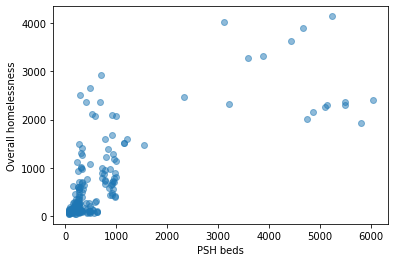

In [ ]:
# plot
plt.scatter(data_fe["psh_beds"], data_fe["all_homeless"], alpha=0.5)
plt.xlabel("PSH beds")
plt.ylabel("Overall homelessness")
plt.show()